In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
# explainable Ai importings
import shap  # Explainable AI
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
file_path = "Datasetforimplementation.csv"
df = pd.read_csv(file_path)



In [5]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)



In [6]:
Encoder = "Label Encoder"
# Encoder = "One-hot Encoder"
# OverSamplingTecnique = ""
# OverSamplingTecnique = "SMOTE"
# OverSamplingTecnique = "SMOTE-Tomek"
OverSamplingTecnique = "SMOTE-Enn"

In [7]:
if Encoder == "Label Encoder":
  print("Applying Label Encoder")
  df_final = df.copy()
  le = LabelEncoder()

  text_data_features = ['Geography', 'Gender']

  print('Label Encoder Transformation')
  for i in text_data_features :
      df_final[i] = le.fit_transform(df_final[i])
      print(i,' : ',df_final[i].unique(),' = ',le.inverse_transform(df_final[i].unique()))



  X = df_final.drop(['Exited'], axis=1).copy()
  Y = df_final['Exited'].copy().astype(int)


Applying Label Encoder
Label Encoder Transformation
Geography  :  [0 2 1]  =  ['France' 'Spain' 'Germany']
Gender  :  [0 1]  =  ['Female' 'Male']


In [8]:
if Encoder == "One-hot Encoder":
  print("Applying One-hot Encoder")

  # One-hot encode categorical columns
  categorical_columns = ['Geography', 'Gender']

  encoder = OneHotEncoder()
  encoded_features = encoder.fit_transform(df[categorical_columns]).toarray()

  # Combine one-hot encoded features with numerical features
  numerical_features = df.drop(categorical_columns + ['Exited'], axis=1)
  X = np.hstack((encoded_features, numerical_features))

  # Manually encode 'Exited' column
  # df['Exited'] = df['Exited'].apply(lambda x: 1 if x == 'Yes' else 0)
  # Extract the target variable Y
  Y = df['Exited'].values


  # Ensure all data is in float format
  X = X.astype(float)
  Y = Y.astype(int)



In [9]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X)
X=X_resampled_scaled
Y=Y

In [10]:

if OverSamplingTecnique == "SMOTE-Enn":
  print("Applying SMOTE-Enn")

  smote_enn = SMOTEENN()
  X_resampled, y_resampled = smote_enn.fit_resample(X, Y)
  scaler = StandardScaler()
  X_resampled_scaled = scaler.fit_transform(X_resampled)
  X=X_resampled_scaled
  y=y_resampled

Applying SMOTE-Enn


In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
def residual_block(x, units):
    shortcut = layers.Dense(units, kernel_regularizer=regularizers.l2(0.001))(x)  # Projection layer
    residual = layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    residual = layers.BatchNormalization()(residual)
    residual = layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(residual)
    return layers.Add()([shortcut, residual])


def spatial_attention(x):
    attention = layers.Dense(1, activation='sigmoid')(x)
    return layers.Multiply()([x, attention])

def create_churn_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = residual_block(x, 128)
    x = layers.Dropout(0.4)(x)
    x = residual_block(x, 64)
    x = spatial_attention(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
# Enable XLA compilation for performance improvement
tf.config.optimizer.set_jit(True)

In [14]:
# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies, precisions, recalls, f1_scores, mcc_scores, roc_aucs = [], [], [], [], [], []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = create_churn_model(X_train.shape[1])

    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    model.compile(optimizer='ADAM', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0, 
              callbacks=[early_stopping, reduce_lr])
    
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

print("Average Accuracy:", np.mean(accuracies))
print("Average Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))
print("Average F1 Score:", np.mean(f1_scores))
print("Average MCC Score:", np.mean(mcc_scores))
print("Average ROC AUC Score:", np.mean(roc_aucs))

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Average Accuracy: 0.9580072465726767
Average Precision: 0.9551778797832009
Average Recall: 0.9708781776305087
Average F1 Score: 0.9629242273052432
Average MCC Score: 0.9147815942773214
Average ROC AUC Score: 0.9908572935771641


In [15]:
# Explainability using SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 1217it [07:09,  2.82it/s]                          


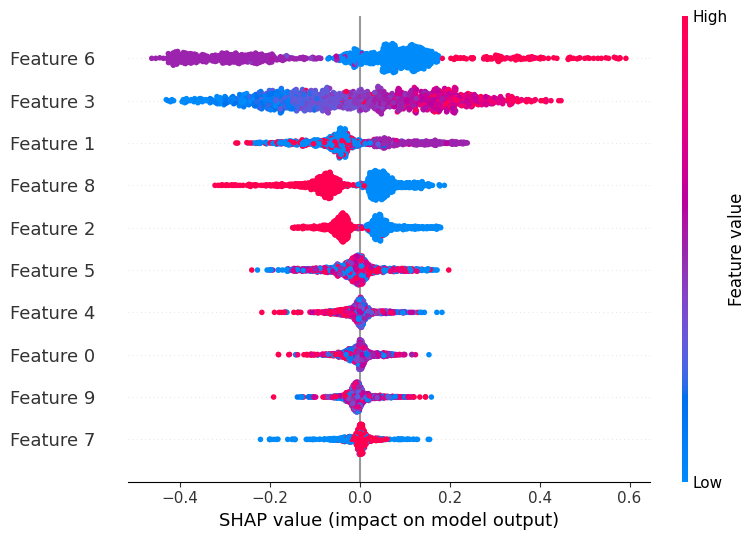

In [16]:
# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

In [17]:
# Initialize model
# input_shape = (X_train.shape[1],)
# model = create_churn_model(input_shape)
# model.summary()



In [18]:
# Train the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)



In [19]:
# Evaluate the model
# y_pred_prob = model.predict(X_test)
# y_pred = (y_pred_prob > 0.5).astype(int)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("ROC AUC Score:", roc_auc)
# print("Confusion Matrix:\n", conf_matrix)
# print("Classification Report:\n", class_report)